# Time series plots for each term of MSE
Creates plots that compare the tendency of each term in MSE budget equation with the overall tendency of MSE.
- NCSU Large-scale and tropical dynamics
- A. Thornton & A. Aiyyer
- Version: Jan 2024
  
4 Different Plots:
1. Time series of all terms in MSE budget for either 850 or 600 hPa track
2. Time series of total MSE, MSE tendency, and filtered v-winds for either 850 and 600 hPa track
3. Bar graph showing relative importance of each term for land vs ocean points at 600 hPa
4. Time series of case-selection process based on filtered v-winds
<br>

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cmaps
import cartopy
import matplotlib.cm as cm

import geocat.viz as gv
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter


# Any import of metpy will activate the accessors
from metpy.units import units

#from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import mixing_ratio_from_specific_humidity, relative_humidity_from_dewpoint

from metpy.calc import vorticity

import pandas as pd

In [2]:
# Selections:
clevs = np.arange(-50,50,5)
level = 600                  # choose 600 or 850

data_path2  = '/glade/scratch/athornton/era5_processed_data/filtered_era5_full_fields/'+str(level)+'/v_'+str(level)+'_filtered_'

year_start  = 1998
year_end    = 2022

data_files_v= [data_path2 + str(year) + '.nc' for year in range(year_start,year_end+1)]
ds_v        = xr.open_mfdataset(data_files_v)
ds_v = ds_v.V_prime.compute()

In [7]:
# Northern Track based on 850 hPa V Variance
if level == 850:
    stormTrackLons = [-50., -34., -20., -11., 0., 14., 30.]
    stormTrackLats = [12., 12., 18., 21.5, 21.5 , 21.5, 16.]

# Southern Track based on 600 hPa V Variance
if level == 600:
    stormTrackLons = [-50., -34., -22., -11., 0., 14., 30. ]
    stormTrackLats = [12., 12., 12., 12., 9., 8, 8.]

In [8]:
variables = [#'v', 'mse',
    #'ubar_hp_dx_vint', 
    'vbar_hp_dy_vint', 
    #'wbar_hp_dp_vint',
    'up_hbar_dx_vint', 'vp_hbar_dy_vint', 'wp_hbar_dp_vint',
    'up_hp_dx_vint', 'vp_hp_dy_vint', 'wp_hp_dp_vint',
    'sshf', 'slhf', 'q'
]

varNames =  [#'V', 'MSE',
    #'ubar_hp_dx_vint', 
    'vbar_hp_dy_vint', 
    #'wbar_hp_dp_vint',
    'up_hbar_dx_vint', 'vp_hbar_dy_vint', 'wp_hbar_dp_vint',
    'up_hp_dx_vint', 'vp_hp_dy_vint', 'wp_hp_dp_vint',
    'SSHF', 'SLHF', 'Q'
]


## Plot each term in MSE budget
use itrack range (1,2) for ocean point and range (4,5) for land point.
<br>
or loop through the length of the storm Track to plot and save all points in path as individual plots

/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/vbar_hp_dy_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/up_hbar_dx_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/vp_hbar_dy_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/wp_hbar_dp_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/up_hp_dx_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/vp_hp_dy_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/wp_hp_dp_vint_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/sshf_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/slhf_filtered_
/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/q_filtered_


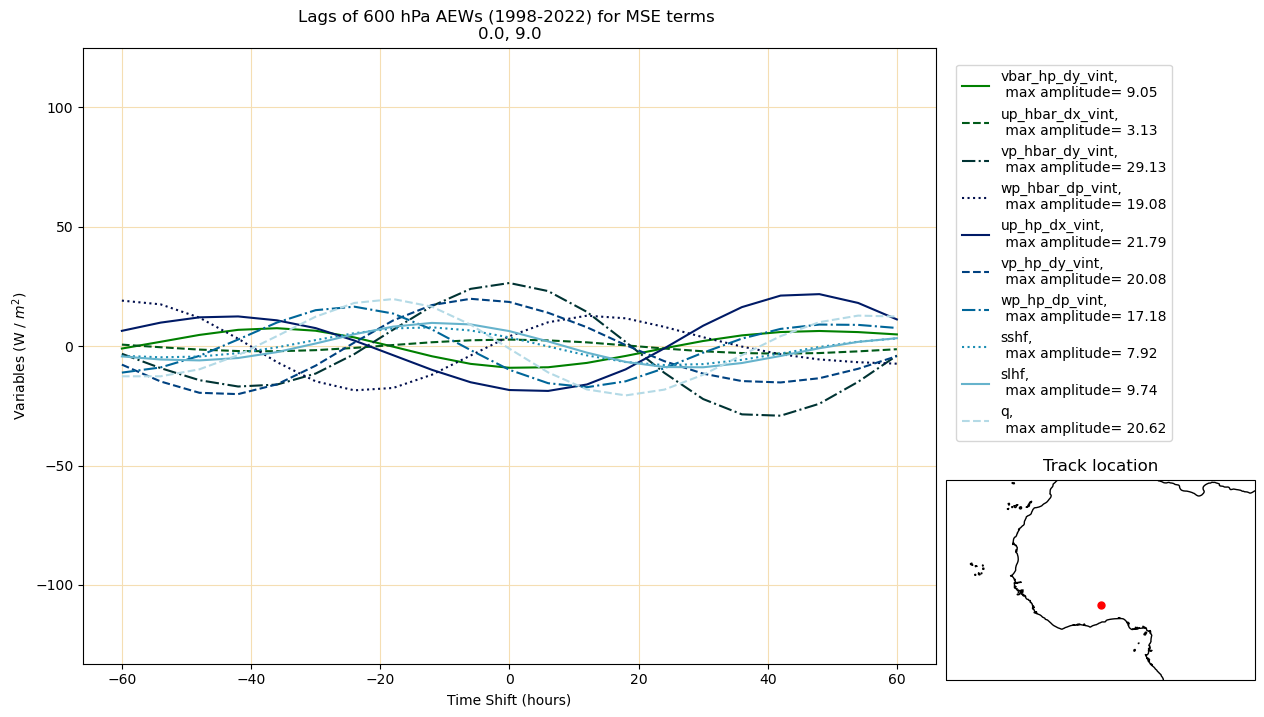

In [10]:
for itrack in range(4,5):#len(stormTrackLons)):
    lon_base = stormTrackLons[itrack]
    lat_base = stormTrackLats[itrack]
    reference_point =  ds_v.sel(latitude = lat_base, longitude=lon_base)
    std = reference_point.std()

    # events now contains the AEW cases for the composite
    threshold = -1.5*std
    events_index = []

    n = int(len(reference_point))
    for i in range(1, n-1):

        # Condition for local minima
        if(reference_point[i] <= threshold) and (reference_point[i-1] > reference_point[i] < reference_point[i + 1]):
            events_index.append(i)

    wave_passage = ds_v[events_index]

    all_lags = []

    for variab, varNam in zip(variables, varNames):
        lag = []

        # path to the data
        
        if (variab == 'mse') or (variab == 'dse'):
            data_path   = '/glade/scratch/athornton/era5_processed_data/static/'+variab+'_vint_filtered_'
        
        elif (variab == 'v'):
            data_path   = '/glade/scratch/athornton/era5_processed_data/filtered_era5_full_fields/'+str(level)+'/v_'+str(level)+'_filtered_'
        else:
            data_path   = '/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/'+variab+'_filtered_'
        
        print(data_path)
        data_files  = [data_path  + str(year) + '.nc' for year in range(year_start,year_end+1)]
        ds          = xr.open_mfdataset(data_files)

        
        if (variab == 'v'):
            ds   = ds[varNam+'_prime'].compute()
        elif (variab == 'mse') or (variab == 'dse'):
            ds    = ds[variab+'_vint_prime'].compute()*(1.e-5)
        else: 
            ds   = ds[varNam+'_prime'].compute()*(-1)
            
        for ih in range (-10,11):
            comp_dates = pd.to_datetime(wave_passage.time) +  pd.Timedelta(6*ih, "hours")
            # make sure that we have only dates within the months July-Sep
            comp_dates = comp_dates[ (comp_dates.month > 6) & (comp_dates.month < 10) ]
            var = ds.sel(time = comp_dates).mean(dim='time', keep_attrs=True)
            var = var.sel(latitude=slice(lat_base+2, lat_base-2), longitude=slice(lon_base-2, lon_base+2)).mean(dim=['latitude','longitude'], keep_attrs=True)
            lag.append(var)
        
        all_lags.append(lag)

    fig, ax1 = plt.subplots(figsize=(11,8))
    plt.rcParams['savefig.dpi'] = 255

    # Time series plotting code for the left y-axis
    colormap = cm.ocean
    v_winds_data = []
    styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
    num_colors = len(variables)
    colors = [colormap(i / num_colors) for i in range(num_colors)]
    #colors = ['darkblue', 'steelblue']

    for variable, lag_data, color, style in zip(variables, all_lags, colors, styles):
        arr = np.array(lag_data)
        absolute = np.abs(arr)
        ax1.plot(range(-60, 61, 6), lag_data, label=variable+',\n max amplitude= '+str(round(max(absolute),2)), color=color, linestyle=style)
    
    ax1.set_title('Lags of '+str(level)+ ' hPa AEWs (1998-2022) for MSE terms \n'+str(lon_base)+', '+str(lat_base))
    ax1.set_xlabel('Time Shift (hours)')
    ax1.set_ylim(-133,125)
    #ax1.set_ylabel('Static energies (W / $m^2$)')
    ax1.set_ylabel('Variables (W / $m^2$)')
    ax1.legend(loc='lower right', bbox_to_anchor=(1.285, 0.35))

    #ax1.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    ax1.grid(True, color='wheat')

    # Add the map subplot to the existing figure
    ax_map = fig.add_axes([0.095, 0.625, 0.25, 0.25], projection=ccrs.PlateCarree())

    if itrack == 6:
        minlon = lon_base - 40.
        maxlon = lon_base + 20.
    elif itrack < 6:
        minlon = lon_base - 30.
        maxlon = lon_base + 30.

    minlat = -5.
    maxlat = 30.

    # Set the extent or specific region for the inset map
    ax_map.set_extent([minlon, maxlon, minlat, maxlat])  

    # Add coastlines and other features to the inset map
    ax_map.add_feature(cfeature.COASTLINE, zorder=1)
    ax_map.plot(lon_base, lat_base, marker='o', markersize=5, color='red', transform=ccrs.PlateCarree())
    ax_map.set_title('Track location')
    ax_map.set_position([0.9, 0.09, 0.30, 0.25])

    #plt.show()

    #plt.savefig('timeseries_removeterms_modax'+str(itrack)+'_'+str(level)+'.png', bbox_inches='tight', facecolor='white')
    #plt.close()


## Compare terms with one another
Reads a csv that I created based on the amplitudes for the land and ocean point in the 600 hpa track

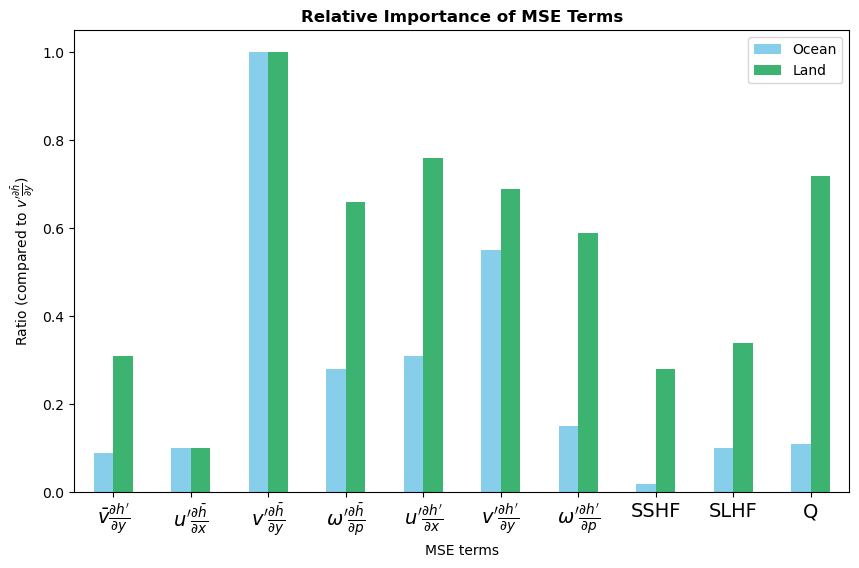

In [45]:
plt.rcParams['savefig.dpi'] = 255

ratio = pd.read_csv('ratio.csv')
# Plotting
ax = ratio.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'mediumseagreen'])

ax.set_xticklabels([
    r'$\bar{v}\frac{\partial h^{\prime}}{\partial y}$',
    r"$u^{\prime} \frac{\partial \bar{h}}{\partial x}$",
    r"$v^{\prime} \frac{\partial \bar{h}}{\partial y}$",
    r"${\omega}^{\prime} \frac{\partial \bar{h}}{\partial p}$",
    r"$u^{\prime} \frac{\partial h^{\prime}}{\partial x}$",
    r"$v^{\prime} \frac{\partial h^{\prime}}{\partial y}$",
    r"$\omega^{\prime} \frac{\partial h^{\prime}}{\partial p}$",
    r'SSHF',
    r'SLHF',
    r'Q'
], rotation='horizontal')
# Adding labels and title
plt.xticks(fontsize=14)

plt.xlabel('MSE terms')
plt.ylabel('Ratio (compared to '+r'$v^{\prime} \frac{\partial \bar{h}}{\partial y}$'+')')
plt.title('Relative Importance of MSE Terms', weight='bold')
plt.legend()

plt.savefig('ratio.png')

In [26]:
itrack = 1

lon_base = stormTrackLons[itrack]
lat_base = stormTrackLats[itrack]
reference_point =  ds_v.sel(latitude = lat_base, longitude=lon_base)
std = reference_point.std()

# events now contains the AEW cases for the composite
threshold = -1.5*std
events_index = []

n = int(len(reference_point))
for i in range(1, n-1):

    # Condition for local minima
    if(reference_point[i] <= threshold) and (reference_point[i-1] > reference_point[i] < reference_point[i + 1]):
        events_index.append(i)

wave_passage = ds_v[events_index]
all_lags = []

data_path_mse = '/glade/scratch/athornton/era5_processed_data/static/mse_vint_filtered_'
data_files_mse  = [data_path_mse  + str(year) + '.nc' for year in range(year_start,year_end+1)]
ds_mse          = xr.open_mfdataset(data_files_mse)
ds_mse          = ds_mse['mse_vint_prime'].compute()*(1.e-5)

data_files_v = [data_path2 + str(year) + '.nc' for year in range(year_start,year_end+1)]
ds_v         = xr.open_mfdataset(data_files_v)
ds_v         = ds_v.V_prime.compute()

v_lag   = []
mse_lag = []
for ih in range (-10,11):
    comp_dates = pd.to_datetime(wave_passage.time) +  pd.Timedelta(6*ih, "hours")
    # make sure that we have only dates within the months July-Sep
    comp_dates = comp_dates[ (comp_dates.month > 6) & (comp_dates.month < 10) ]
    var_v = ds_v.sel(time = comp_dates).mean(dim='time', keep_attrs=True)
    var_v = var_v.sel(latitude=slice(lat_base+2, lat_base-2), longitude=slice(lon_base-2, lon_base+2)).mean(dim=['latitude','longitude'], keep_attrs=True)
    var_mse = ds_mse.sel(time = comp_dates).mean(dim='time', keep_attrs=True)
    var_mse = var_mse.sel(latitude=slice(lat_base+2, lat_base-2), longitude=slice(lon_base-2, lon_base+2)).mean(dim=['latitude','longitude'], keep_attrs=True)
    v_lag.append(var_v)
    mse_lag.append(var_mse)

In [27]:
new = np.array(mse_lag)
tendency = np.gradient(new)

(-95.0, 95.0)

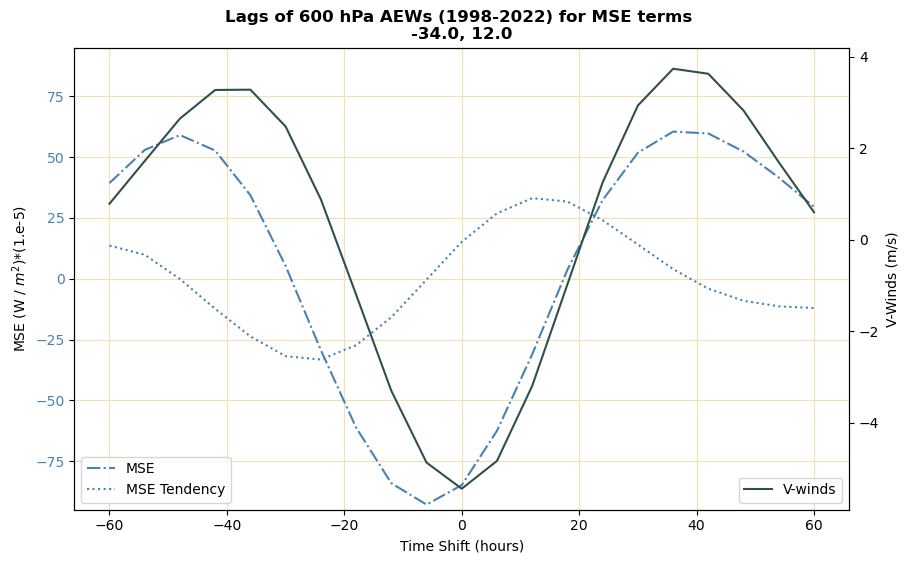

In [43]:
fig = plt.figure(figsize=(10,6))
plt.rcParams['savefig.dpi'] = 255

ax1 = plt.subplot(1,1,1)

#for variable, lag_data, color, style in zip(variables, all_lags, colors, styles):
ax1.plot(range(-60, 61, 6), mse_lag, label='MSE', color='steelblue', linestyle='-.')

ax1.set_title('Lags of '+str(level)+ ' hPa AEWs (1998-2022) for MSE terms \n'+str(lon_base)+', '+str(lat_base), weight='bold')
ax1.set_xlabel('Time Shift (hours)')
ax1.set_ylabel('MSE (W / $m^2$)*(1.e-5)')
ax1.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, color='wheat')

ax2 = ax1.twinx()
ax2.plot(range(-60, 61, 6), v_lag, label='V-winds', color='darkslategray', linestyle='solid')
ax1.plot(range(-60, 61, 6), tendency, label='MSE Tendency', color='steelblue', linestyle=':')
ax2.legend(loc='lower right')
ax2.set_ylabel('V-Winds (m/s)')
ax1.legend(loc='lower left')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_ylim(-95,95)


#plt.tight_layout()
#plt.savefig('timeseries_'+str(itrack)+'_mse_v.png', bbox_inches='tight')

## Case Selection Time Series
Plot that describes how cases are selected within each season of filtered v-winds for each location.

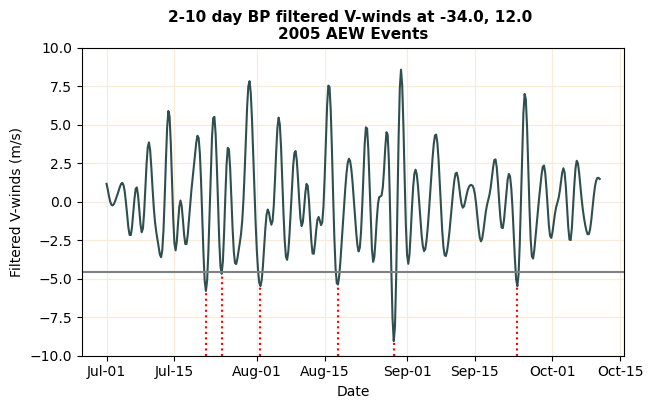

In [48]:
ds_v = xr.open_mfdataset(data_files_v)
ds_v = ds_v.V_prime.compute()

winds = ds_v.sel(latitude=slice(lat_base+2, lat_base-2), longitude=slice(lon_base-2, lon_base+2)).mean(dim=['latitude','longitude'], keep_attrs=True)
winds = winds.sel(time=slice('07-01-2005', '12-31-2005'))

events_index = []

n = int(len(winds))
for i in range(1, n-1):

    # Condition for local minima
    if(winds[i] <= threshold) and (winds[i-1] > winds[i] < winds[i + 1]):
        events_index.append(i)

fig, ax = plt.subplots(figsize=(7,4))
## Quality of image
plt.rcParams['savefig.dpi'] = 255

time = winds.time
date_form = DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(date_form)
plt.plot(time, winds, color='darkslategray')
plt.axhline(y=threshold, color='gray', linestyle='-')

value = winds[events_index]
ax.grid(True, color='antiquewhite')
ax.set_xlabel('Date')
ax.set_ylim(-10,10)
ax.set_ylabel('Filtered V-winds (m/s)')
ax.set_title('2-10 day BP filtered V-winds at '+str(lon_base)+', '+str(lat_base)+' \n2005 AEW Events', weight='bold', size=11)
ax.vlines(value.time, -10, value, linestyles='dotted', colors='red')

plt.savefig('case_selection.png')